In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Image Enhancement**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
from PIL import Image
import cv2

In [ ]:
import tensorflow as tf

if tf.test.gpu_device_name():

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [ ]:
list_high =os.listdir("/content/drive/MyDrive/ML_projects/Underwater/underwater_clahe")

In [ ]:
print(len(list_high))

448


In [ ]:
list_low =os.listdir("/content/drive/MyDrive/ML_projects/Underwater/underwater_dark")

In [ ]:
first_image = cv2.imread("/kaggle/input/underwater/under/trainB-20231002T065649Z-001/trainB/266208_00006275.jpg")

In [ ]:
first_image.shape

(256, 256, 3)

In [ ]:
image_low = []
image_high = []
for img_name in list_low:
    img_high = Image.open("/content/drive/MyDrive/ML_projects/Underwater/underwater_clahe/"+img_name)
    img_arr_high = np.asarray(img_high)

    img_low = Image.open("/content/drive/MyDrive/ML_projects/Underwater/underwater_dark/"+img_name)
    img_arr_low = np.asarray(img_low)

    img_arr_high = cv2.resize(img_arr_high,(96, 96))
    img_arr_low = cv2.resize(img_arr_low,(96, 96))

    image_low.append(img_arr_low)
    image_high.append(img_arr_high)

In [ ]:
image_low[0].shape

(96, 96, 3)

In [ ]:
image_high[0].shape

(96, 96, 3)

In [ ]:
image_low = np.array(image_low)

In [ ]:
image_low.shape

(448, 96, 96, 3)

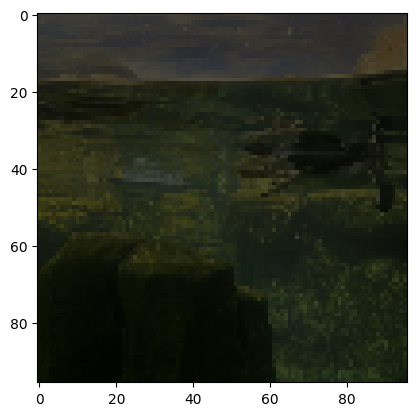

In [ ]:
plt.imshow(image_low[68])

In [ ]:
image_high = np.array(image_high)

In [ ]:
image_high.shape

(448, 96, 96, 3)

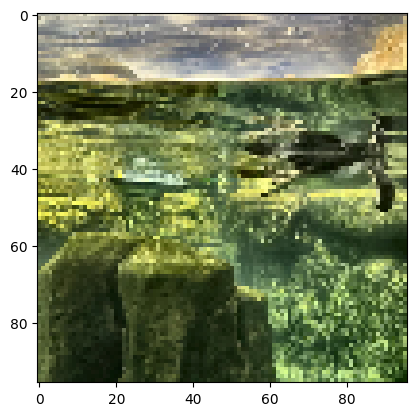

In [ ]:
plt.imshow(image_high[68])

In [ ]:
np.save(open("image_low.npy","wb+"),image_low)

In [ ]:
np.save(open("image_high.npy","wb+"),image_high)

In [ ]:
img_high = np.load("image_high.npy")

In [ ]:
img_low = np.load("image_low.npy")

In [ ]:
# import os

In [ ]:
# os.chdir(r'/kaggle/working')

In [ ]:
# from IPython.display import FileLink
# # FileLink(r'image_high.npy')

In [ ]:
img_high = img_high/255

In [ ]:
img_low = img_low/255

In [ ]:
# # Convert lists to NumPy arrays
# image_low = np.array(image_low) / 255.0  # Normalize pixel values
# image_high = np.array(image_high) / 255.0  # Normalize pixel values

In [ ]:
# # Save the processed images as NumPy arrays
# np.save("image_low.npy", image_low)
# np.save("image_high.npy", image_high)

In [ ]:
# import os
# os.chdir(r'/kaggle/working')
# from IPython.display import FileLink
# FileLink(r'image_low.npy')

In [ ]:
# import os
# os.chdir(r'/kaggle/working')
# from IPython.display import FileLink
# FileLink(r'image_high.npy')

In [ ]:
# img_low = np.load("image_low.npy")
# img_high = np.load("image_high.npy")

**Illumination Mask Network**

In [ ]:
input_layer_1 = keras.layers.Input(shape=(96, 96,3)) #  input layer is intended for images with dimensions 1024x768 pixels and 3 color channels (RGB)

In [ ]:
top=keras.layers.Conv2D(64,kernel_size=(3,3),input_shape=(96, 96,3),padding='same')(input_layer_1) # convolutional layer with 64 filters, a kernel size of (3, 3), and 'same' padding
top=keras.layers.Conv2D(64,kernel_size=(3,3),padding='same')(top) # adds another convolutional layer with the same settings as the previous one

In [ ]:
top.get_shape

<bound method KerasTensor.get_shape of <KerasTensor: shape=(None, 96, 96, 64) dtype=float32 (created by layer 'conv2d_1')>>

In [ ]:
bottom_inp=input_layer_1 # assigns the input_layer_1 to a variable called bottom_inp
bottom_resize=tf.keras.layers.Lambda(
    lambda img: tf.image.resize(img,(60, 60)) # you use a lambda function within a Lambda layer to resize the images
)(bottom_inp)

In [ ]:
bottom=keras.layers.Conv2D(64,kernel_size=(3,3),input_shape=(60, 60),padding='same')(bottom_resize) #  line defines a convolutional layer with 64 filters, a kernel size of (3, 3), and 'same' padding. It takes the resized images (bottom_resize) as its input.
bottom=keras.layers.Conv2D(64,kernel_size=(3,3),padding='same')(bottom)
bottom=keras.layers.Conv2D(64,kernel_size=(3,3),padding='same')(bottom) # These lines add two more convolutional layers to the "bottom" branch, both with 64 filters and 'same' padding.

In [ ]:
bottom.get_shape()

TensorShape([None, 60, 60, 64])

In [ ]:
bottom = tf.keras.layers.experimental.preprocessing.Resizing(96, 96)(bottom) # Resizing layer from TensorFlow's experimental preprocessing module to resize the "bottom" branch output images back to dimensions (1024, 768)

In [ ]:
bottom.get_shape()

TensorShape([None, 96, 96, 64])

In [ ]:
top.get_shape()

TensorShape([None, 96, 96, 64])

In [ ]:
merged=keras.layers.concatenate([top,bottom]) # you concatenate the outputs of the "top" and "bottom" branches along the channel axis, creating a merged feature map

In [ ]:
merged

<KerasTensor: shape=(None, 96, 96, 128) dtype=float32 (created by layer 'concatenate')>

In [ ]:
merged=keras.layers.Conv2D(32,kernel_size=(7,7),padding='same')(merged)
merged=keras.layers.Conv2D(8,kernel_size=(1,1),padding='same')(merged)
merged=keras.layers.Conv2D(1,kernel_size=(5,5),activation='sigmoid',padding='same')(merged) # final convolutional layer with a single filter, a kernel size of (5, 5), and a sigmoid activation function. It is used for binary image segmentation, where the output represents a binary mask.

In [ ]:
merged.get_shape()

TensorShape([None, 96, 96, 1])

In [ ]:
model_illumination_mask=keras.models.Model(inputs=input_layer_1,outputs=merged) # Keras model named model_illumination_mask with input_layer_1 as the input and merged as the output

In [ ]:
model_illumination_mask.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 lambda (Lambda)             (None, 60, 60, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv2d_2 (Conv2D)           (None, 60, 60, 64)           1792      ['lambda[0][0]']              
                                                                                                  
 conv2d_3 (Conv2D)           (None, 60, 60, 64)           36928     ['conv2d_2[0][0]']            
                                                                                              

**Ilumination Map**

In [ ]:
merged.get_shape

<bound method KerasTensor.get_shape of <KerasTensor: shape=(None, 96, 96, 1) dtype=float32 (created by layer 'conv2d_7')>>

In [ ]:
merged=keras.layers.Concatenate()([input_layer_1,merged])

In [ ]:
merged

<KerasTensor: shape=(None, 96, 96, 4) dtype=float32 (created by layer 'concatenate_1')>

![](https://www.researchgate.net/publication/366357680/figure/fig1/AS:11431281115872931@1675134641974/The-Convolutional-Block-Attention-Module-CBAM-The-upper-side-is-the-channel-attention.png/)

In [ ]:
def ieb(input_feature):
    ieb1=keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu',padding='same')(input_feature) # 2D convolutional layer with 32 filters, a kernel size of (3, 3), ReLU activation, and 'same' padding is applied to the input_feature tensor
    ieb1=keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu',padding='same')(ieb1) # adding more layers of convolution to the feature extraction process

    max_pool=keras.layers.GlobalMaxPooling2D()(ieb1) # max-pooling layer is applied to the ieb1 tensor, which reduces the spatial dimensions by taking the maximum value across each feature map
    avg_pool=keras.layers.GlobalAveragePooling2D()(ieb1) # average-pooling layer is applied to the ieb1 tensor, computing the average value across each feature map

    dense1=keras.layers.Dense(8,activation='relu')
    dense2=keras.layers.Dense(32,activation='sigmoid')
    max_pool=dense1(max_pool)
    max_pool=dense2(max_pool)
    avg_pool=dense1(avg_pool)
    avg_pool=dense2(avg_pool)

    channel=keras.layers.Add()([max_pool,avg_pool]) # outputs of the max-pooling and average-pooling branches are added element-wise using keras.layers.Add(). This combines the information from both branches.
    ieb1=keras.layers.Multiply()([ieb1,channel]) # ieb1 tensor (output of the second convolutional layer) is multiplied element-wise by the result of the addition with channel
    '''tensors typically have four axis representing:
        axis 1: Batch size (number of samples in a batch)
        axis 2: Height (vertical dimension)
        axis 3: Width (horizontal dimension)
        axis 4: Channels (e.g., color channels in RGB images)'''
    max_pool_s=tf.keras.layers.Lambda(lambda x: keras.backend.max(x,axis=3,keepdims=True))(ieb1) # fourth axis (3) typically corresponds to the channel or feature map axis. Computes the maximum value across feature maps (along axis 3) and keeps the result as a separate channel
    avg_pool_s=keras.layers.Lambda(lambda x: keras.backend.mean(x,axis=3,keepdims=True))(ieb1) # computes the mean value across feature maps (along axis 3) and keeps the result as a separate channel.
    concat_slayers=keras.layers.Concatenate(axis=3)([avg_pool_s,max_pool_s]) # outputs of avg_pool_s and max_pool_s are concatenated along axis 3, resulting in a tensor with two channels
    spacial=keras.layers.Conv2D(1,7,activation='sigmoid',padding='same')(concat_slayers) # 2D convolutional layer with 1 filter, a kernel size of 7, sigmoid activation, and 'same' padding is applied to the concatenated tensor
    ieb1=keras.layers.Multiply()([ieb1,spacial]) # ieb1 tensor is multiplied element-wise by the result of the convolutional layer with spacial

    ieb1=keras.layers.BatchNormalization()(ieb1)
    ieb1=keras.layers.Activation('relu')(ieb1)

    return ieb1


In [ ]:
ieb_1=ieb(merged)
ieb_2=ieb(ieb_1)
ieb_3=ieb(ieb_2)
ieb_4=ieb(ieb_3)
ieb_5=ieb(ieb_4)

In [ ]:
added_ieb=keras.layers.concatenate([ieb_1,ieb_2,ieb_3,ieb_4,ieb_5])

added_ieb

<KerasTensor: shape=(None, 96, 96, 160) dtype=float32 (created by layer 'concatenate_7')>

In [ ]:
ilmnet=keras.layers.Conv2D(32,(3,3),padding='same')(added_ieb)
ilmnet=keras.layers.Conv2D(8,(3,3),padding='same')(ilmnet)
ilmnet=keras.layers.Conv2D(1,(3,3),padding='same')(ilmnet)

In [ ]:
s_l = keras.layers.Lambda(
    lambda input:input[0]/input[1]
)([input_layer_1,ilmnet])

In [ ]:
s_l

<KerasTensor: shape=(None, 96, 96, 3) dtype=float32 (created by layer 'lambda_11')>

**Correction Network**

In [ ]:
def correction_network(input_feature):

    conv1=keras.layers.Conv2D(32,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(input_feature)
    conv2=keras.layers.Conv2D(32,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(conv1)
    conv3=keras.layers.Conv2D(16,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(conv2)
    conv4=keras.layers.Conv2D(16,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(conv3)
    conv5=keras.layers.Conv2D(3,kernel_size=(3,3),strides=(1,1),activation='sigmoid',padding='same')(conv4)

    return conv5

In [ ]:
final_output = correction_network(s_l)

In [ ]:
final_output

<KerasTensor: shape=(None, 96, 96, 3) dtype=float32 (created by layer 'conv2d_30')>

**Custom Loss Function**

In [ ]:
import keras.backend as K

In [ ]:
def enhancement_loss(x,y):
    x=K.cast(x,dtype='float32')
    y=K.cast(y,dtype='float32')
    norm=tf.norm(x-y)
    return norm

In [ ]:
enhancement_loss(img_low[0],img_high[0])

<tf.Tensor: shape=(), dtype=float32, numpy=63.175594>

In [ ]:
def color_loss(x,y):
    x=K.cast(x,dtype='float32')
    y=K.cast(y,dtype='float32')
    cosine_loss = keras.losses.CosineSimilarity()(x,y)
    colorloss=1-cosine_loss
    return colorloss

In [ ]:
color_loss(img_low[0],img_high[0])

<tf.Tensor: shape=(), dtype=float32, numpy=1.9584422>

In [ ]:
sobelFilter = K.variable([[[[1.,  1.]], [[0.,  2.]],[[-1.,  1.]]],
                      [[[2.,  0.]], [[0.,  0.]],[[-2.,  0.]]],
                      [[[1., -1.]], [[0., -2.]],[[-1., -1.]]]])

In [ ]:
def expandedSobel(inputTensor):
    inputChannels = K.reshape(K.ones_like(inputTensor[0,0,0,:]),(1,1,-1,1))
    return sobelFilter * inputChannels

In [ ]:
def squareSobelLoss(yTrue,yPred):

    yTrue=K.cast(yTrue,dtype='float32')
    yPred=K.cast(yPred,dtype='float32')
    filt = expandedSobel(yTrue)
    squareSobelTrue =K.square(K.depthwise_conv2d(yTrue,filt))
    squareSobelPred =K.square(K.depthwise_conv2d(yPred,filt))
    newShape = K.shape(squareSobelTrue)
    newShape = K.concatenate([newShape[:-1],
                            newShape[-1:]//2,
                            K.variable([2],dtype='int32')])
    squareSobelTrue = K.sum(K.reshape(squareSobelTrue,newShape),axis=-1)
    squareSobelPred = K.sum(K.reshape(squareSobelPred,newShape),axis=-1)
    return K.mean(K.abs(squareSobelTrue - squareSobelPred))

In [ ]:
def max_rgb_filter(img):
    r=img[:,:,:,0]
    g=img[:,:,:,1]
    b=img[:,:,:,2]
    max_c=tf.maximum(K.maximum(r,g),b)
    return tf.expand_dims(max_c,axis=-1)

def light_mask_loss(input_img,pred_img,true_img):
    pred_img=tf.cast(pred_img,tf.uint8)
    true_img=tf.cast(true_img,tf.uint8)
    input_img=tf.cast(input_img,tf.uint8)
    m_i=max_rgb_filter(input_img)
    m_t=max_rgb_filter(true_img)
    m_div_it=tf.divide(m_i,m_t)
    m_div_it=tf.cast(m_div_it,tf.uint8)
    light_mask=tf.subtract(pred_img,m_div_it)
    light_mask=tf.cast(light_mask,tf.float32)
    lightmask_loss=tf.norm(light_mask)
    return lightmask_loss

In [ ]:
a1=max_rgb_filter(tf.expand_dims(img_low[1],axis=0))
a2=max_rgb_filter(tf.expand_dims(img_high[1],axis=0))
b=a1/a2
img_low[0]-b

<tf.Tensor: shape=(1, 96, 96, 3), dtype=float64, numpy=
array([[[[-0.24215686, -0.25      ,  0.04411765],
         [-0.18263305, -0.19047619,  0.10364146],
         [-0.18660131, -0.19444444,  0.0996732 ],
         ...,
         [-0.25248869, -0.24072398, -0.16621418],
         [-0.23714986, -0.22538515, -0.15479692],
         [-0.25668449, -0.23707665, -0.16256684]],

        [[-0.20954817, -0.20954817,  0.07672634],
         [-0.19670232, -0.20062389,  0.08565062],
         [-0.24215686, -0.25      ,  0.04411765],
         ...,
         [-0.24020989, -0.24413146, -0.17354322],
         [-0.34793028, -0.35185185, -0.27734205],
         [-0.2801021 , -0.28402367, -0.217357  ]],

        [[-0.1010043 , -0.05394548,  0.13821138],
         [-0.15804661, -0.13059563,  0.11254162],
         [-0.21229465, -0.21229465,  0.06221516],
         ...,
         [-0.29166667, -0.29166667, -0.21323529],
         [-0.24080417, -0.24472574, -0.1741375 ],
         [-0.25350417, -0.25742574, -0.18683751]

In [ ]:
def custom_loss_wrapper(input_tensor):
      def custom_loss(y_true,y_pred):
        # lm_loss=light_mask_loss(input_img=input_tensor,pred_img=y_pred,true_img=y_true)
        # print(lm_loss)
        e_loss=enhancement_loss(y_true,y_pred)
        c_loss=color_loss(y_true,y_pred)
        s_loss=squareSobelLoss(y_true,y_pred)
        total_loss=e_loss+s_loss*0.2+0.2*c_loss
        # total_loss=total_loss+(10*lm_loss)
        return total_loss
      return custom_loss

In [ ]:
def MeanGradientError(outputs, targets):
    outputs=tf.cast(outputs,dtype='float32')
    targets=tf.cast(targets,dtype='float32')
    filter_x = tf.tile(tf.expand_dims(tf.constant([[-1, -2, -2], [0, 0, 0], [1, 2, 1]], dtype = 'float32'), axis = -1), [1, 1, outputs.shape[-1]])
    filter_x = tf.tile(tf.expand_dims(filter_x, axis = -1), [1, 1, 1, outputs.shape[-1]])
    filter_y = tf.tile(tf.expand_dims(tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = 'float32'), axis = -1), [1, 1, targets.shape[-1]])
    filter_y = tf.tile(tf.expand_dims(filter_y, axis = -1), [1, 1, 1, targets.shape[-1]])

    # output gradient
    output_gradient_x = tf.math.square(tf.nn.conv2d(outputs, filter_x, strides = 1, padding = 'SAME'))
    output_gradient_y = tf.math.square(tf.nn.conv2d(outputs, filter_y, strides = 1, padding = 'SAME'))

    #target gradient
    target_gradient_x = tf.math.square(tf.nn.conv2d(targets, filter_x, strides = 1, padding = 'SAME'))
    target_gradient_y = tf.math.square(tf.nn.conv2d(targets, filter_y, strides = 1, padding = 'SAME'))

    # square
    output_gradients = tf.math.sqrt(tf.math.add(output_gradient_x, output_gradient_y))
    target_gradients = tf.math.sqrt(tf.math.add(target_gradient_x, target_gradient_y))

    # compute mean gradient error
    shape = output_gradients.shape[1:3]
    mge = tf.math.reduce_sum(tf.math.squared_difference(output_gradients, target_gradients) / (shape[0] * shape[1]))
    return mge

**Model**

In [ ]:
model=keras.models.Model(inputs=[input_layer_1],outputs=final_output)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 lambda (Lambda)             (None, 60, 60, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv2d_2 (Conv2D)           (None, 60, 60, 64)           1792      ['lambda[0][0]']              
                                                                                                  
 conv2d_3 (Conv2D)           (None, 60, 60, 64)           36928     ['conv2d_2[0][0]']            
                                                                                            

**DL Model**

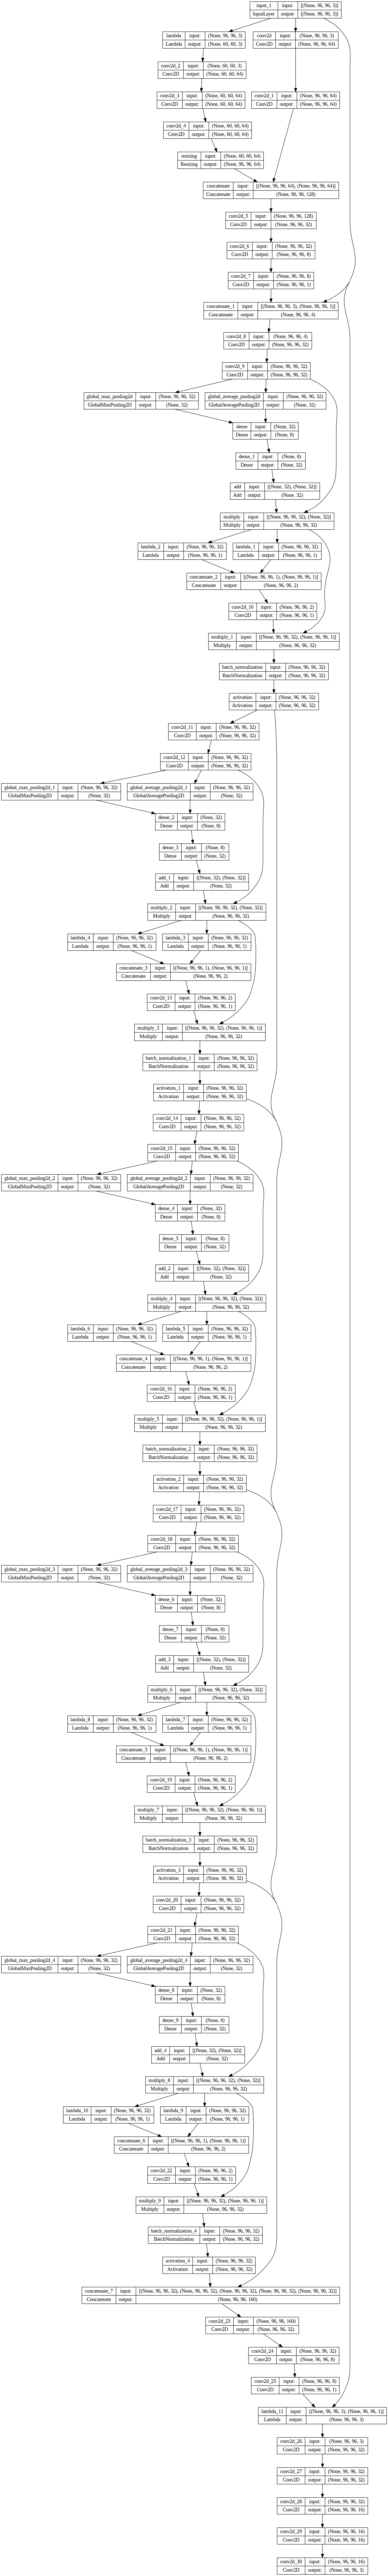

In [ ]:
keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

**Model Compile**

In [ ]:
opt=tf.optimizers.Adam(learning_rate=0.001)

In [ ]:
EPOCHS=5
BATCH=28

In [ ]:
import os
import random

In [ ]:
for i in range(EPOCHS):

    b=0
    for j in range(0,img_high.shape[0],BATCH):

        b=b+1
        img_inp=img_low[j:j+BATCH]
        img_out=img_high[j:j+BATCH]
        with tf.GradientTape() as tape:

            img_pred=model([img_inp])
            # print(img_pred)
            lm_loss=light_mask_loss(input_img=img_inp,pred_img=img_pred,true_img=img_out)
            e_loss=enhancement_loss(img_out,img_pred)
            c_loss=color_loss(img_out,img_pred)
            s_loss=MeanGradientError(img_out,img_pred)
            total_loss= (e_loss*3) + (s_loss*0.25) + (c_loss*1) + (lm_loss*5)
              # according to paper:- total_loss=e_loss*1+s_loss*0.2+c_loss*1+lm_loss*10
            mse=tf.losses.mse(img_out,img_pred).numpy().sum()
            # os.system('cls')
            print(i,' ',b,' ',total_loss.numpy(),' ',mse)
            grads = tape.gradient(total_loss, model.trainable_variables)
            clipped_grads, _ = tf.clip_by_global_norm(grads, clip_norm=1.0)
            opt.apply_gradients(zip(clipped_grads, model.trainable_variables))
#             opt.apply_gradients(zip(grads, model.trainable_variables))


0   1   1233.3962   36349.098
0   2   716.43427   14264.203
0   3   749.87854   16308.93
0   4   732.7472   15725.074
0   5   867.349   14910.172
0   6   1770.0065   40366.008
0   7   nan   nan
0   8   nan   nan
0   9   nan   nan
0   10   nan   nan
0   11   nan   nan
0   12   nan   nan
0   13   nan   nan
0   14   nan   nan
0   15   nan   nan
0   16   nan   nan
1   1   nan   nan
1   2   nan   nan
1   3   nan   nan
1   4   nan   nan
1   5   nan   nan
1   6   nan   nan
1   7   nan   nan
1   8   nan   nan
1   9   nan   nan
1   10   nan   nan
1   11   nan   nan
1   12   nan   nan


In [ ]:
# model.compile(optimizer=keras.optimizers.Adam(),loss=custom_loss_wrapper(input_layer_1),metrics=[keras.metrics.MSE])

In [ ]:
# img_high.shape

(5550, 96, 96, 3)

In [ ]:
# tf.config.run_functions_eagerly(True)

In [ ]:
# import numpy as np
# from tensorflow import keras
# from tensorflow.keras.preprocessing import image
# import cv2

# # Load the pre-trained model from the .h5 file
# model = keras.models.load_model('/content/drive/MyDrive/ML_projects/model_improved.h5')  # Replace 'your_model.h5' with the actual model file path

# # Load and preprocess a single image for testing
# image_path = '/content/drive/MyDrive/ML_projects/underwater_test/1.png'  # Replace with the path to your test image
# img = image.load_img(image_path, target_size=(96, 96))  # Resize the image to match the model's input size
# img_array = image.img_to_array(img)
# img_array /= 255.0  # Normalize pixel values to [0, 1]
# img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension

# # Make a prediction using the loaded model
# prediction = model.predict(img_array)

# # Assuming your model outputs an image, you can save the prediction
# # as an image if needed
# output_image = prediction[0] * 255  # Scale the prediction back to [0, 255] range
# output_image = np.clip(output_image, 0, 255).astype(np.uint8)  # Clip values and convert to uint8
# output_image = cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR)  # Convert to BGR format if necessary

# # Save the output image
# output_image_path = 'output_image.jpg'
# cv2.imwrite(output_image_path, output_image)

# print('Prediction saved as', output_image_path)


ValueError: ignored